In [13]:
from linares_plot import *
import sys, os
path_tools = 'C:\\Users\\David\\Documents\\GitHub\\encoding\\scripts\\wm_representation\\functions\\IEM\\tools'
sys.path.insert(1, path_tools)
from timecourse import *
from tiemcourse_substraction import *

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# paths_=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainT_testT_runsout.xlsx', 
#                'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainD_testD_runsout.xlsx']

# paths_shuff=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainT_testT_runsout.xlsx', 
#                      'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainD_testD_runsout.xlsx']


In [32]:
paths_=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainT_testT_runsout.xlsx', 
               'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainT_testD_runsout.xlsx']

paths_shuff=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainT_testT_runsout.xlsx', 
                     'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainT_testD_runsout.xlsx']


In [24]:
paths_=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainT_testT_resp.xlsx', 
               'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_trainT_testD_resp.xlsx']

paths_shuff=[ 'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainT_testT_resp.xlsx', 
                     'C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_trainT_testD_resp.xlsx']


In [33]:
df_=[] ##target ha sido entrenado en el delay del distractor y viceversa
df_shuff=[]

for PathI in paths_:
    path_save_signal =PathI
    #
    decoding_item= path_save_signal.split('\\')[-1].split('.')[0].split('_')[2][-1]
    training_item = path_save_signal.split('\\')[-1].split('.')[0].split('_')[1][-1]
    #
    df_x = pd.read_excel(PathI)
    df_x['decoding_item'] = decoding_item
    df_x['training_item'] =training_item
    
    #
    df_.append(df_x)
    
#
df_=pd.concat(df_, axis=0)
df_['decoding_item'] = df_['decoding_item'].replace(['T', 'D'], ['target', 'distractor'])
df_['training_item'] = df_['training_item'].replace(['T', 'D'], ['target', 'distractor'])


####################

for PathI in paths_shuff:
    path_sh_signal =PathI
    #
    decoding_item= path_sh_signal.split('\\')[-1].split('.')[0].split('_')[3][-1]
    training_item = path_sh_signal.split('\\')[-1].split('.')[0].split('_')[2][-1]
    #
    df_x = pd.read_excel(PathI)
    df_x['decoding_item'] = decoding_item
    df_x['training_item'] =training_item
    
    #
    df_shuff.append(df_x)
    
#
df_shuff=pd.concat(df_shuff, axis=0)
df_shuff['decoding_item'] = df_shuff['decoding_item'].replace(['T', 'D'], ['target', 'distractor'])
df_shuff['training_item'] = df_shuff['training_item'].replace(['T', 'D'], ['target', 'distractor'])

In [34]:
df_time=[]

for cond in ['1_0.2','1_7', '2_0.2', '2_7']:
    for reg in ['visual', 'ips', 'pfc']:
        for subj in ['d001', 's001', 'l001', 'n001', 'b001', 'r001']:
            for training_item in ['target', 'distractor']:
                for decoding_item in ['target', 'distractor']:
                    for t in df_.times.unique(): 
                        #
                        dec_sig = df_.loc[(df_['region']==reg) & (df_['times']== t) & 
                               ( df_['condition']==cond) & (df_['subject']==subj) &  
                               ( df_['training_item']==training_item) & 
                               ( df_['decoding_item']== decoding_item)]
                        #
                        dec_shuff = df_shuff.loc[(df_shuff['region']==reg) & (df_shuff['times']== t) & 
                               ( df_shuff['condition']==cond) & (df_shuff['subject']==subj) &  
                               ( df_shuff['training_item']==training_item)  & 
                               ( df_shuff['decoding_item']== decoding_item) ].decoding
                        #
                        try:
                            decoding_ = (dec_sig.decoding.iloc[0]  - dec_shuff.mean()) / dec_shuff.std()
                            #decoding_ = dec_sig.decoding.iloc[0]  - dec_shuff.mean()
                            df_time.append( [t, decoding_, reg, subj, cond, dec_sig.label.iloc[0], training_item, decoding_item] )   
                        except:
                            pass
                        
                        ####
#
df_time = pd.DataFrame(df_time)
df_time.columns=['times', 'decoding', 'region', 'subject', 'condition', 'label', 'training_item', 'decoding_item']

In [35]:
df_targ = df_time.loc[(df_time['training_item']=='target') & (df_time['decoding_item']=='target')]
df_dist = df_time.loc[(df_time['training_item']=='target') & (df_time['decoding_item']=='distractor')]

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


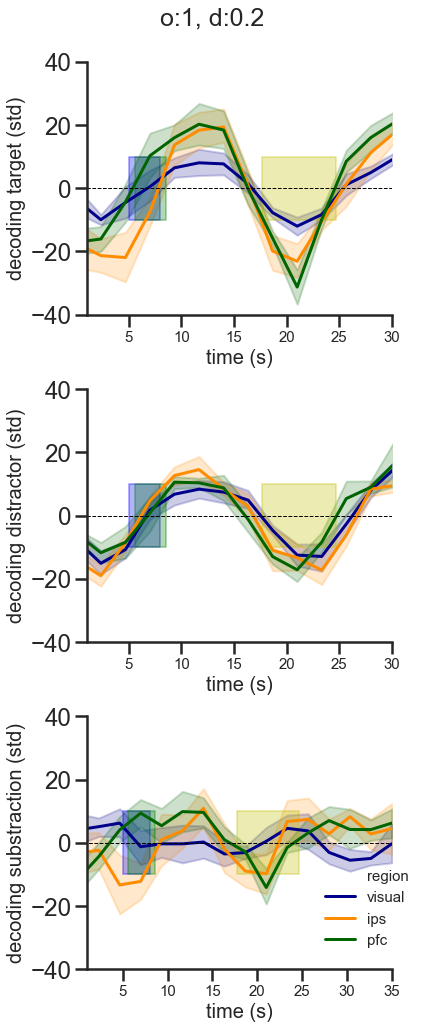

In [36]:
tiemcourse_substraction(df_targ, df_dist, condition='1_0.2', title_plot='o:1, d:0.2', ylims=[-40,40]) ##resp

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


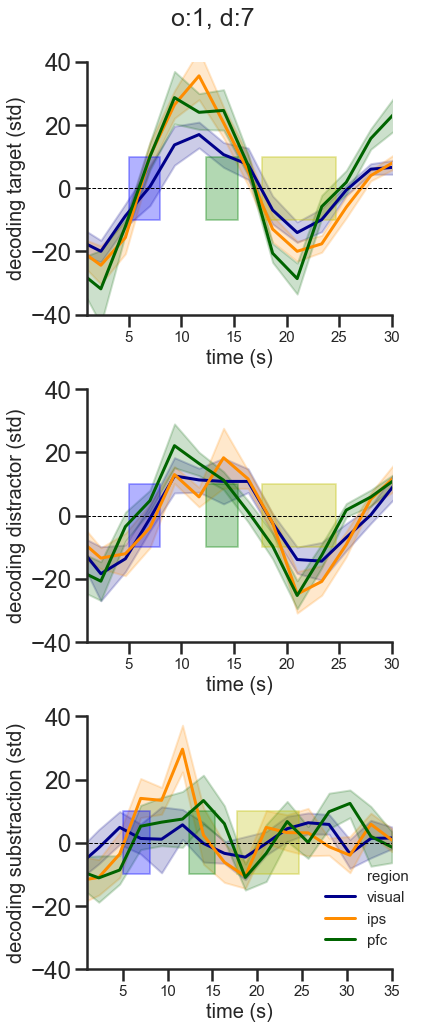

In [37]:
tiemcourse_substraction(df_targ, df_dist, condition='1_7', title_plot='o:1, d:7', ylims=[-40,40]) ##resp

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


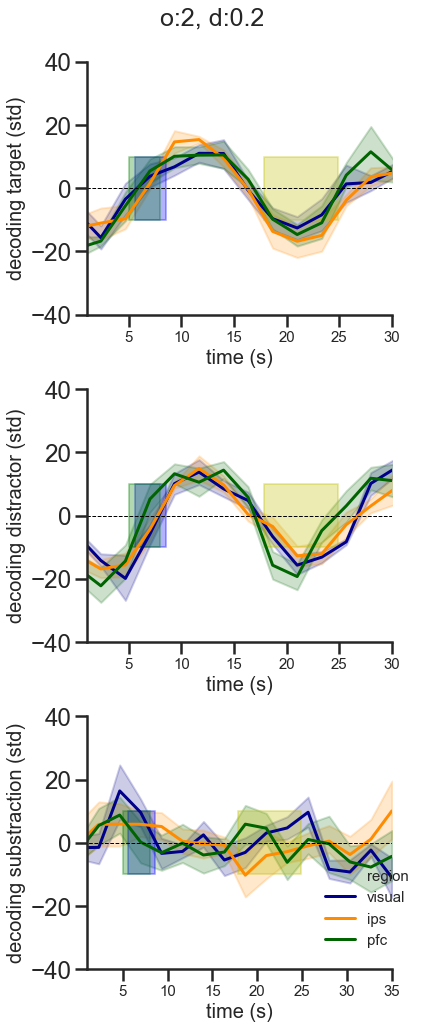

In [38]:
tiemcourse_substraction(df_targ, df_dist, condition='2_0.2', title_plot='o:2, d:0.2', ylims=[-40,40]) ##resp

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


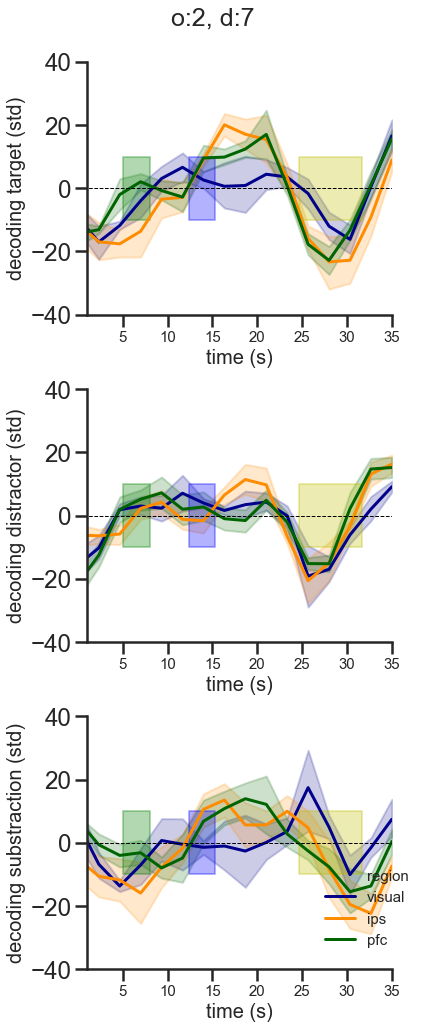

In [39]:
tiemcourse_substraction(df_targ, df_dist, condition='2_7', title_plot='o:2, d:7', ylims=[-40,40])

In [ ]:
linares_plot(x='region', y='decoding', hue='training_item', order=['visual', 'ips', 'pfc'], 
             hue_order=['target', 'distractor'],
            df=df_distractor_distractor, 
            palette=['#285d9d', '#f55528'], CI=0.95,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=100, alpha_box=0.7, alpha=0.6,  point_size=10, leg=True, sep_axis=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('')
plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('decoding (std)')# (std. dist.)')
plt.gca().set_ylim(-5,20)
plt.gca().set_yticks([-5,0,10,20])
plt.title('distractor decoding ')
plt.show()